**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [0]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy.utilities.lambdify import lambdify
import sympy as sp

In [0]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p output

# Gradient Descent

This notebook is going to illustrate how gradient descent works. Let us recall that gradient descent is an gradient-based iterative optimization method. The optimization starts from a certain initial point $\mathbf{x}_0$, which is at each step being shifted a little against the direction of the gradient. Since gradient represents the direction of the steepest ascent of a function at the specified point, by going against the direction of the gradient the function will be minimized.

The update rule which is applied at every step to compute the next point $\mathbf{x}_{i+1}$ is as follows:

\begin{equation}
\mathbf{x}_{i+1} = \mathbf{x}_i - \gamma \nabla f(\mathbf{x}_i)
\end{equation}

where $\nabla f(\mathbf{x}_i)$ is the gradient of the minimized function and $\gamma$ (a small number from interval $( 0, 1 \rangle$) is the learning rate.

## Minimization of a Paraboloid: An Example

As an example that illustrates gradient descent we are going to use the minimization of a simple function – a paraboloid according to:

\begin{equation}
z = f(x, y) = x^2 + y^2
\end{equation}

### Visualization of the Paraboloid

As the first step we are going to define and visualize the function:

In [0]:
def f(x, y):
    return x**2 + y**2

We are going to generate all combinations of points $x, y$ from a certain range and compute $z = f(x, y)$ for them:

In [0]:
xx, yy = np.mgrid[-10:10.2:0.2, -10:10.2:0.2]
zz = f(xx, yy)

We are going to visualize the results in a 3D plot:

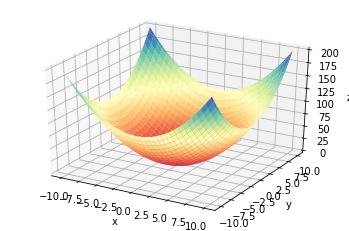

In [5]:
plt.figure()
ax = plt.gca(projection='3d')
ax.plot_surface(xx, yy, zz, cmap='Spectral',
                linewidth=0, antialiased=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.savefig("output/gradient_3d_plot.pdf")

3D plots are notorious for being hard to read because some of their elements tend to overlap with each other. To make our plots more readable we will therefore use 2D contour plots instead of 3D plots:

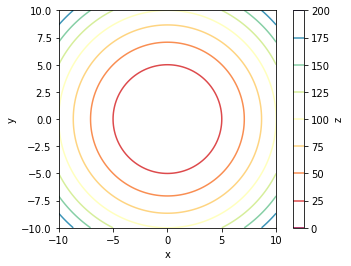

In [6]:
plt.figure()
plt.contour(xx, yy, zz, cmap='Spectral')
# both axes at the same scale + create a legend
plt.gca().set_aspect('equal')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar(label='z')
plt.savefig("output/gradient_func_contour.pdf",
            bbox_inches="tight",
            pad_inches=0)

Let's wrap this code in an auxiliary function so that we need not repeat it each time from now on:

In [0]:
def plot_func(xx, yy, f, X=None):
    if not X is None:
        Xmin, Xmax = X[:, 0].min(), X[:, 0].max() 
        Ymin, Ymax = X[:, 1].min(), X[:, 1].max()
        
        if (Xmin < xx.min() or Xmax > xx.max() or
                Ymin < yy.min() or Ymax > yy.max()):            
            xx = np.linspace(Xmin, Xmax, 100)
            yy = np.linspace(Ymin, Ymax, 100)
            xx, yy = np.meshgrid(xx, yy)
            
        plt.scatter(X[:, 0], X[:, 1], zorder=10)
        
    zz = f(xx, yy)
    plt.contour(xx, yy, zz, cmap='Spectral')
    # both axes at the same scale + create a legend
    plt.gca().set_aspect('equal')
    plt.xlabel('x'); plt.ylabel('y')
    plt.colorbar(label='z')

## Gradient of a Function

To be able to minimize function $f(x, y)$ using gradient descent, we need to determine its gradient. Let us recall that gradient $\nabla f(x, y)$ of function $f(x, y)$ is the vector of its first-order partial derivatives. In our case therefore:

\begin{equation}
\nabla f(x, y) = \left(
    \frac{\partial f}{\partial x},
    \frac{\partial f}{\partial y}
\right)
\end{equation}

Let us also recall that our function has the form of $f(x, y) = x^2 + y^2$. It is therefore easy to determine the partial derivatives. When computing the partial derivative by $x$, term $y^2$ will be considered a constant and we will only be differentiating $x^2$. When computing the partial derivative by $y$ it will be vice versa. And so we obtain:

\begin{align}
\frac{\partial f}{\partial x} &= 2x \\[0.75em]
\frac{\partial f}{\partial y} &= 2y
\end{align}

Our iterative update rule was expressed in vector form – that is to say, for our function with two arguments $x, y$, vector $\mathbf{x}$ will be 2-dimensional and it will take the form of $\mathbf{x} = (x, y)$.

---
### Task 1: Computing the Gradient

**Fill in the blanks in the following cell so that function ``grad_f`` will return the gradient of function $f(x, y)$:**

---

In [0]:
def grad_f(x, y):
    return np.array([2*x,2*y])    # ----





## Visualizing the Gradient

As we know, the gradient of a function indicates the direction of its steepest ascent. To get a better idea of what this means we can visualize the gradient, which we have just defined:

In [0]:
xxg, yyg = np.mgrid[-10:11:1.5, -10:11:1.5]
gg = np.array(
    [[grad_f(x, y) for x, y in zip(rx, ry)] 
          for rx, ry in zip(xxg, yyg)]
)

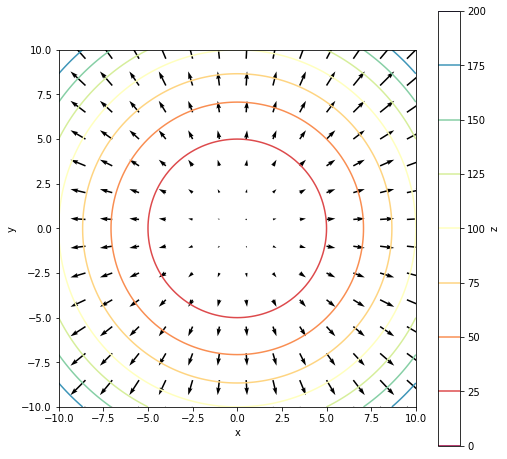

In [16]:
plt.figure(figsize=[8,8])
plot_func(xx, yy, f)
plt.quiver(xxg, yyg, gg[..., 0], gg[..., 1])
plt.savefig("output/gradient_func_quiver.pdf",
            bbox_inches="tight",
            pad_inches=0)

The arrows indicate the gradient's direction. As we can see, they are all pointing outwards – in the direction the paraboloid increases. The size of the arrows indicates the magnitude of the gradient. The arrows close to the centre are tiny (the derivative at a minimum is zero) and they grow towards the margins: because the function grows faster and faster.

## Gradient Descent

Now we will continue by applying gradient descent in order to minimize our function. As the first step we will define a few parameters: the number of steps and the learning rate:

In [0]:
num_steps = 20
learning_rate = 0.1

We will store all the computed points in a matrix so that we can later visualize them. The matrix will have 2 columns – one for $x$ and the other for $y$:

Aby sme si mohli neskôr postup minimalizácie vizualizovať, uložíme si všetky vypočítané body do matice. Matica má 2 stĺpce – jeden pre $x$ a druhý pre $y$:

In [0]:
X = np.zeros((num_steps + 1, 2))

The initial point can either be selected randomly:

In [0]:
X[0] = np.random.uniform(-10, 10, (2,))

or we can opt in for some fixed point, so that we get the same result every time:

In [0]:
X[0] = [-9, -8]

Let us once again recall our iterative update rule for computing the next point:
\begin{equation}
\mathbf{x}_{i+1} = \mathbf{x}_i - \gamma \nabla f(\mathbf{x}_i)
\end{equation}
where $\gamma$ is the learning rate and $\nabla f(\mathbf{x}_i)$ is the gradient of the function we are going to minimize.

---
### Task 2: Implementing Gradient Descent

**Fill in the blanks in the following cell (rewrite the update rule in code):**

---

In [0]:
for i in range(num_steps):
    
    
    X[i+1] =  X[i] - learning_rate*grad_f(X[i,0], X[i,1])
    
    
    

The computed points can finally be visualized and we can ascertain that they really do converge to the minimum of the paraboloid:

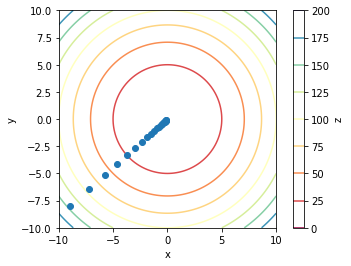

In [22]:
plot_func(xx, yy, f, X)
plt.savefig("output/gradient_mini_steps.pdf",
            bbox_inches="tight",
            pad_inches=0)

---

### Task 3: Wrapping the Code in a Function

**Let us now again wrap this piece of code in a function so that we can call it repeatedly:**

---

In [0]:
def grad_desc(grad_func, init_point,
              num_steps, learning_rate):
    X = np.zeros((num_steps + 1, 2))
    X[0] = init_point
    
    for i in range(num_steps):
        
        
        X[i+1] =  X[i] - learning_rate*grad_f(X[i,0], X[i,1])
        
        
    
    return X

We can test our new function using:

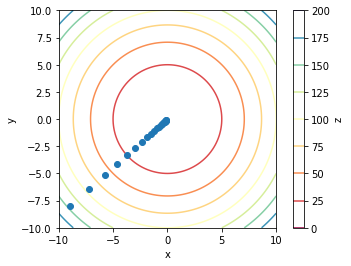

In [24]:
X = grad_desc(grad_f, init_point=[-9, -8],
              num_steps=20, learning_rate=0.1)
plot_func(xx, yy, f, X)

## Testing Different Learning Rates

To illustrate how things work we will now try doing gradient descent with different learning rates.

Let's start with $\gamma = 0.45$:

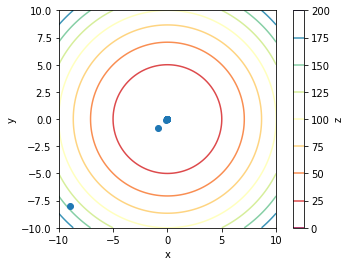

In [25]:
X = grad_desc(grad_f, init_point=[-9, -8], num_steps=20,
      learning_rate=0.45
)
plot_func(xx, yy, f, X)
plt.savefig("output/gradient_lr_0_45.pdf",
            bbox_inches="tight",
            pad_inches=0)

For $\gamma = 1.0$ the algorithm will start to oscillate and it will no longer converge to the minimum:

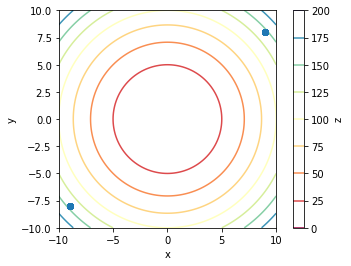

In [26]:
X = grad_desc(grad_f, init_point=[-9, -8], num_steps=20,
      learning_rate=1.0
)
plot_func(xx, yy, f, X)
plt.savefig("output/gradient_lr_1_0.pdf",
            bbox_inches="tight",
            pad_inches=0)

With $\gamma > 1$ the algorithm will start to diverge and it will actually keep moving away from the minimum:

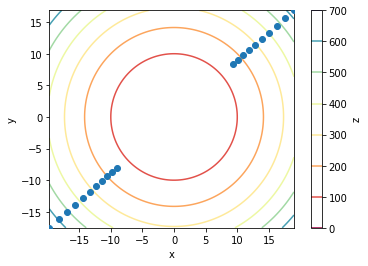

In [27]:
X = grad_desc(grad_f, init_point=[-9, -8], num_steps=20,
      learning_rate=1.02
)
plot_func(xx, yy, f, X)
plt.savefig("output/gradient_lr_1_02.pdf",
            bbox_inches="tight",
            pad_inches=0)

## Computing Symbolic Gradient Automatically

When deriving the gradient of our function above we have computed it analytically and then rewrote it as source code by hand. However, in Python it is possible to compute the symbolic gradient automatically – using the ``sympy`` package. In the following example we will show how this can be done.

We will start by defining some symbolic variables that we are going to need – $x$ and $y$ in our case:

In [0]:
symx, symy = sp.symbols('x y')

We will now define function $f(x, y)$ using the symbolic variables:

In [30]:
symf = symx**2 + symy**2
symf

x**2 + y**2

When computing the symbolic gradient we will use a little trick. We will first transform our scalar function into matrix form and then compute its Jacobian. We will get a row vector that corresponds to the gradient as a result:

In [34]:
sym_grad_f = sp.Matrix([symf]).jacobian([symx, symy])
sym_grad_f

Matrix([[2*x, 2*y]])

To be able to use the resulting symbolic representation of gradient to actually compute it for particular values, we'll need to convert it to a standard numeric function. We will also do the same for function $f$:

In [0]:
f = lambdify((symx, symy), symf, "numpy")
grad_f = lambdify((symx, symy), sym_grad_f, "numpy")

We can now apply gradient descent in exactly the same way we did before – but now we no longer need to compute the gradient by hand:

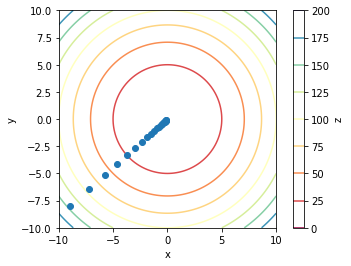

In [40]:
xx, yy = np.mgrid[-10:10.2:0.2, -10:10.2:0.2]
zz = f(xx, yy)

X = grad_desc(grad_f, init_point=[-9, -8],
              num_steps=20, learning_rate=0.1)
plot_func(xx, yy, f, X)